# Result of time-domain inference on GW150914

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import h5ify 
import bilby
from scipy.stats import norm, gaussian_kde
import shutil
from tqdm import tqdm
import lal

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.lines import Line2D
import seaborn as sns
cmap1 = sns.color_palette('colorblind')
cmap2 = sns.color_palette('dark')

import sys, os
sys.path.append('/home/simona.miller/time-domain-gw-inference')
from time_domain_gw_inference import group_postprocess, utils, run_sampler, waveform_h5s

### Load in result
Load in the time-domain inference result using the functionality of `group_postprocess`.

In [2]:
run = '250721_output_longer_seg'

# Load in the result
TD_result = group_postprocess.load_run_settings_from_directory(
    'output/'+run,
    filename_dict={'full':'full_0.0seconds'}
)

# Likelihood manager 
lm = TD_result['runs']['full']['likelihood_manager']  

# Extract the posterior
TD_posterior = TD_result['dfs']['full']
TD_posterior['polarization'] = TD_posterior['polarization'] % np.pi

Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


Load in the `bilby` result for comparison.

In [3]:
# Load in the result
FD_result = h5ify.load(
    os.path.join('output/'+run, TD_result['runs']['full']['args'].pe_posterior_h5_file)
)

# Extract the posterior
FD_posterior = FD_result['C01:IMRPhenomXPHM']['posterior_samples']

## Plot comparison

The two codes use different naming keys for the parameters, so we must set up a dictionary to translate between them:

In [4]:
# keys = bilby keys; values = TD keys
key_transform = {
    'mass_ratio':'mass_ratio', 
    'total_mass':'total_mass',
    'mass_1':'mass1',
    'mass_2':'mass2',
    'luminosity_distance':'luminosity_distance',
    'a_1':'spin1_magnitude',
    'a_2':'spin2_magnitude',
    'tilt_1':'tilt1',
    'tilt_2':'tilt2',
    'phi_12':'phi12',
    'phi_jl':'phi_jl',
    'theta_jn':'theta_jn',
    'ra':'right_ascension', 
    'dec':'declination',
    'psi':'polarization',
    'phase':'phase',
    'geocent_time':'geocenter_time'
}

In [5]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
from collections import namedtuple

def calc_median_error(jsvalues, quantiles=(0.16, 0.84)):
    quants_to_compute = np.array([quantiles[0], 0.5, quantiles[1]])
    quants = np.percentile(jsvalues, quants_to_compute * 100)
    summary = namedtuple("summary", ["median", "lower", "upper"])
    summary.median = quants[1]
    summary.plus = quants[2] - summary.median
    summary.minus = summary.median - quants[0]
    return summary

def calculate_js(samplesA, samplesB, ntests=100, xsteps=100, nsamples=None):
    js_array = np.zeros(ntests)
    for j in range(ntests):
        if nsamples is None:
            nsamples = min([len(samplesA), len(samplesB)])
        A = np.random.choice(samplesA, size=nsamples, replace=False)
        B = np.random.choice(samplesB, size=nsamples, replace=False)
        xmin = np.min([np.min(A), np.min(B)])
        xmax = np.max([np.max(A), np.max(B)])
        x = np.linspace(xmin, xmax, xsteps)
        A_pdf = gaussian_kde(A)(x)
        B_pdf = gaussian_kde(B)(x)

        js_array[j] = np.nan_to_num(np.power(jensenshannon(A_pdf, B_pdf), 2))

    return calc_median_error(js_array)

In [6]:
# make empty dict
JSD_dict = {}

# we care about masses and spins; there are slightly different naming conventions 
# between the two codes
param_names = ['total_mass', 'mass_ratio', 'mass1', 'mass2', 
               'chi_effective', 'chi_precessing', 'spin1_magnitude', 'spin2_magnitude'] 
param_names_bilby = ['total_mass', 'mass_ratio', 'mass_1', 'mass_2', 
                     'chi_eff', 'chi_p', 'a_1', 'a_2'] 

# cycle through parameters
for pb,p in key_transform.items():

    # calculate JSD
    JSD = calculate_js(
        FD_posterior[pb], 
        TD_posterior[p],
        ntests=10, 
        nsamples=5000
    )

    # print its information
    JSD_str = f"JSD: {JSD.median * 1e3:0.1f}+{JSD.plus * 1e3:0.1f}-{JSD.minus * 1e3:0.1f} mb"
    print(pb, JSD_str)

    # add to dict
    JSD_dict[pb] = JSD.median

mass_ratio JSD: 10.5+0.5-1.2 mb
total_mass JSD: 21.4+0.7-2.0 mb
mass_1 JSD: 3.9+0.4-0.3 mb
mass_2 JSD: 21.8+1.3-2.1 mb
luminosity_distance JSD: 3.3+0.2-0.4 mb
a_1 JSD: 10.7+1.5-1.3 mb
a_2 JSD: 3.2+0.3-0.5 mb
tilt_1 JSD: 5.5+0.6-0.3 mb
tilt_2 JSD: 4.6+0.6-0.5 mb
phi_12 JSD: 0.4+0.1-0.1 mb
phi_jl JSD: 11.7+0.5-0.7 mb
theta_jn JSD: 5.8+0.8-0.2 mb
ra JSD: 1.8+0.3-0.4 mb
dec JSD: 3.8+0.4-0.3 mb
psi JSD: 1.2+0.1-0.2 mb
phase JSD: 4.6+0.3-0.3 mb
geocent_time JSD: 3.5+0.6-0.3 mb


Generate comparison plot for the two posteriors

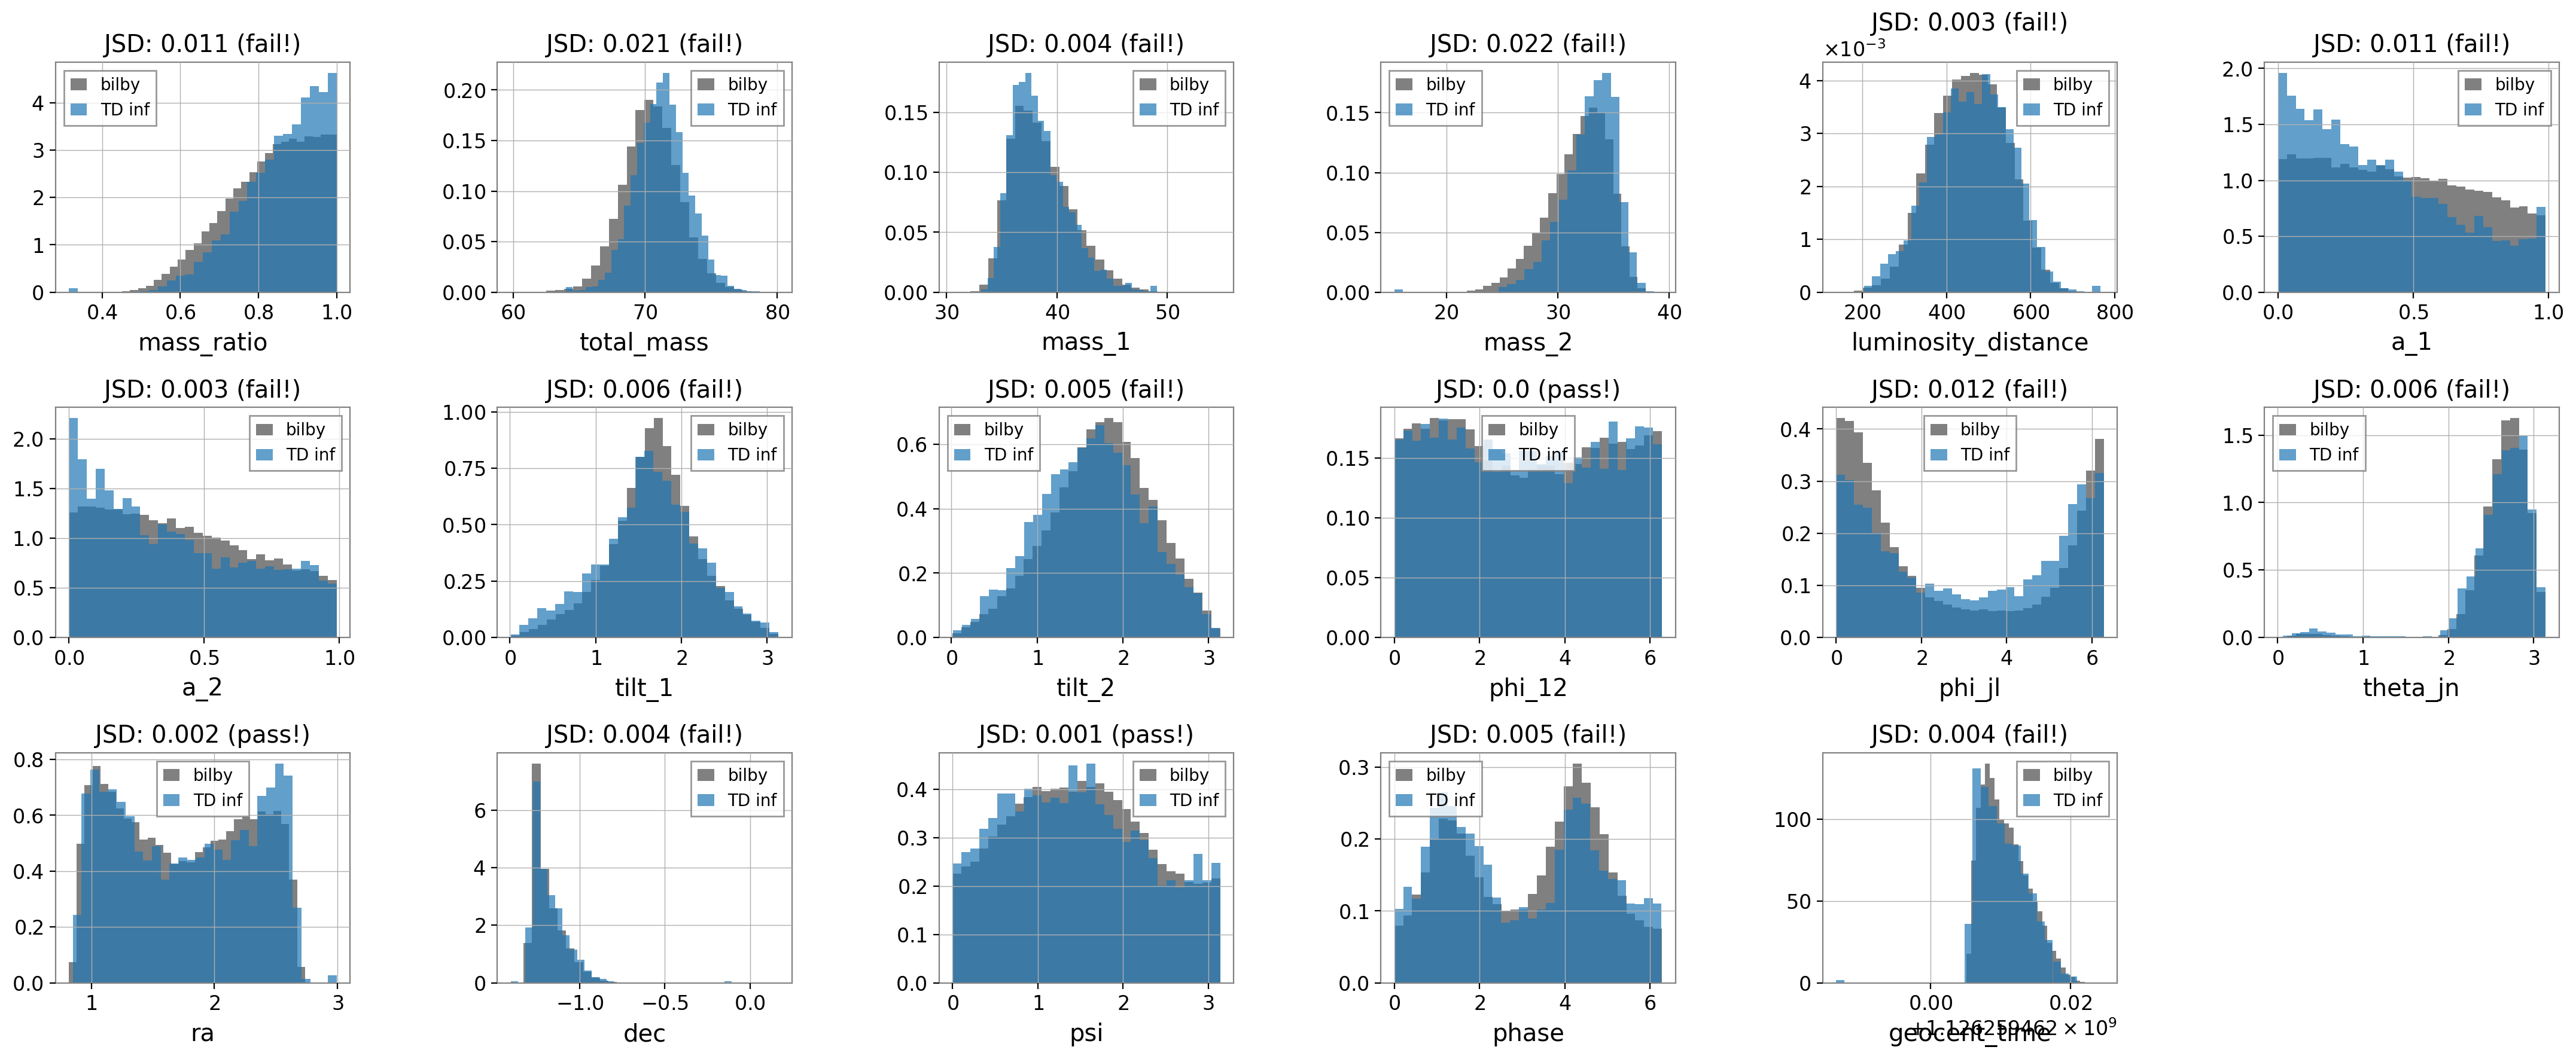

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

for k, ax in zip(key_transform.keys(), axes.flatten()): 

    hist_kws = dict(density=True, bins=30)
    ax.hist(FD_posterior[k], **hist_kws, color='gray',label='bilby')
    ax.hist(TD_posterior[key_transform[k]], **hist_kws,  alpha=0.7, label='TD inf')
        
    ax.set_xlabel(k)
    ax.legend(fontsize=10)

    JS = round(JSD_dict[k], 3)
    if JS <= 0.002:
        ax.set_title('JSD: '+str(JS)+' (pass!)')
    else: 
        ax.set_title('JSD: '+str(JS)+' (fail!)') 
    
plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes[-1][-1].set_visible(False)
plt.show()

Check for convergence by comparing to previous run

In [11]:
run2 = '250715_output'

# Load in the result
TD_result2 = group_postprocess.load_run_settings_from_directory(
    'output/'+run2,
    filename_dict={'full':'full_0.0seconds'}
)

# Extract the posterior
TD_posterior2 = TD_result2['dfs']['full']
TD_posterior2['polarization'] = TD_posterior2['polarization'] % np.pi

Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
Using H1_time posterior to calculate t0.
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


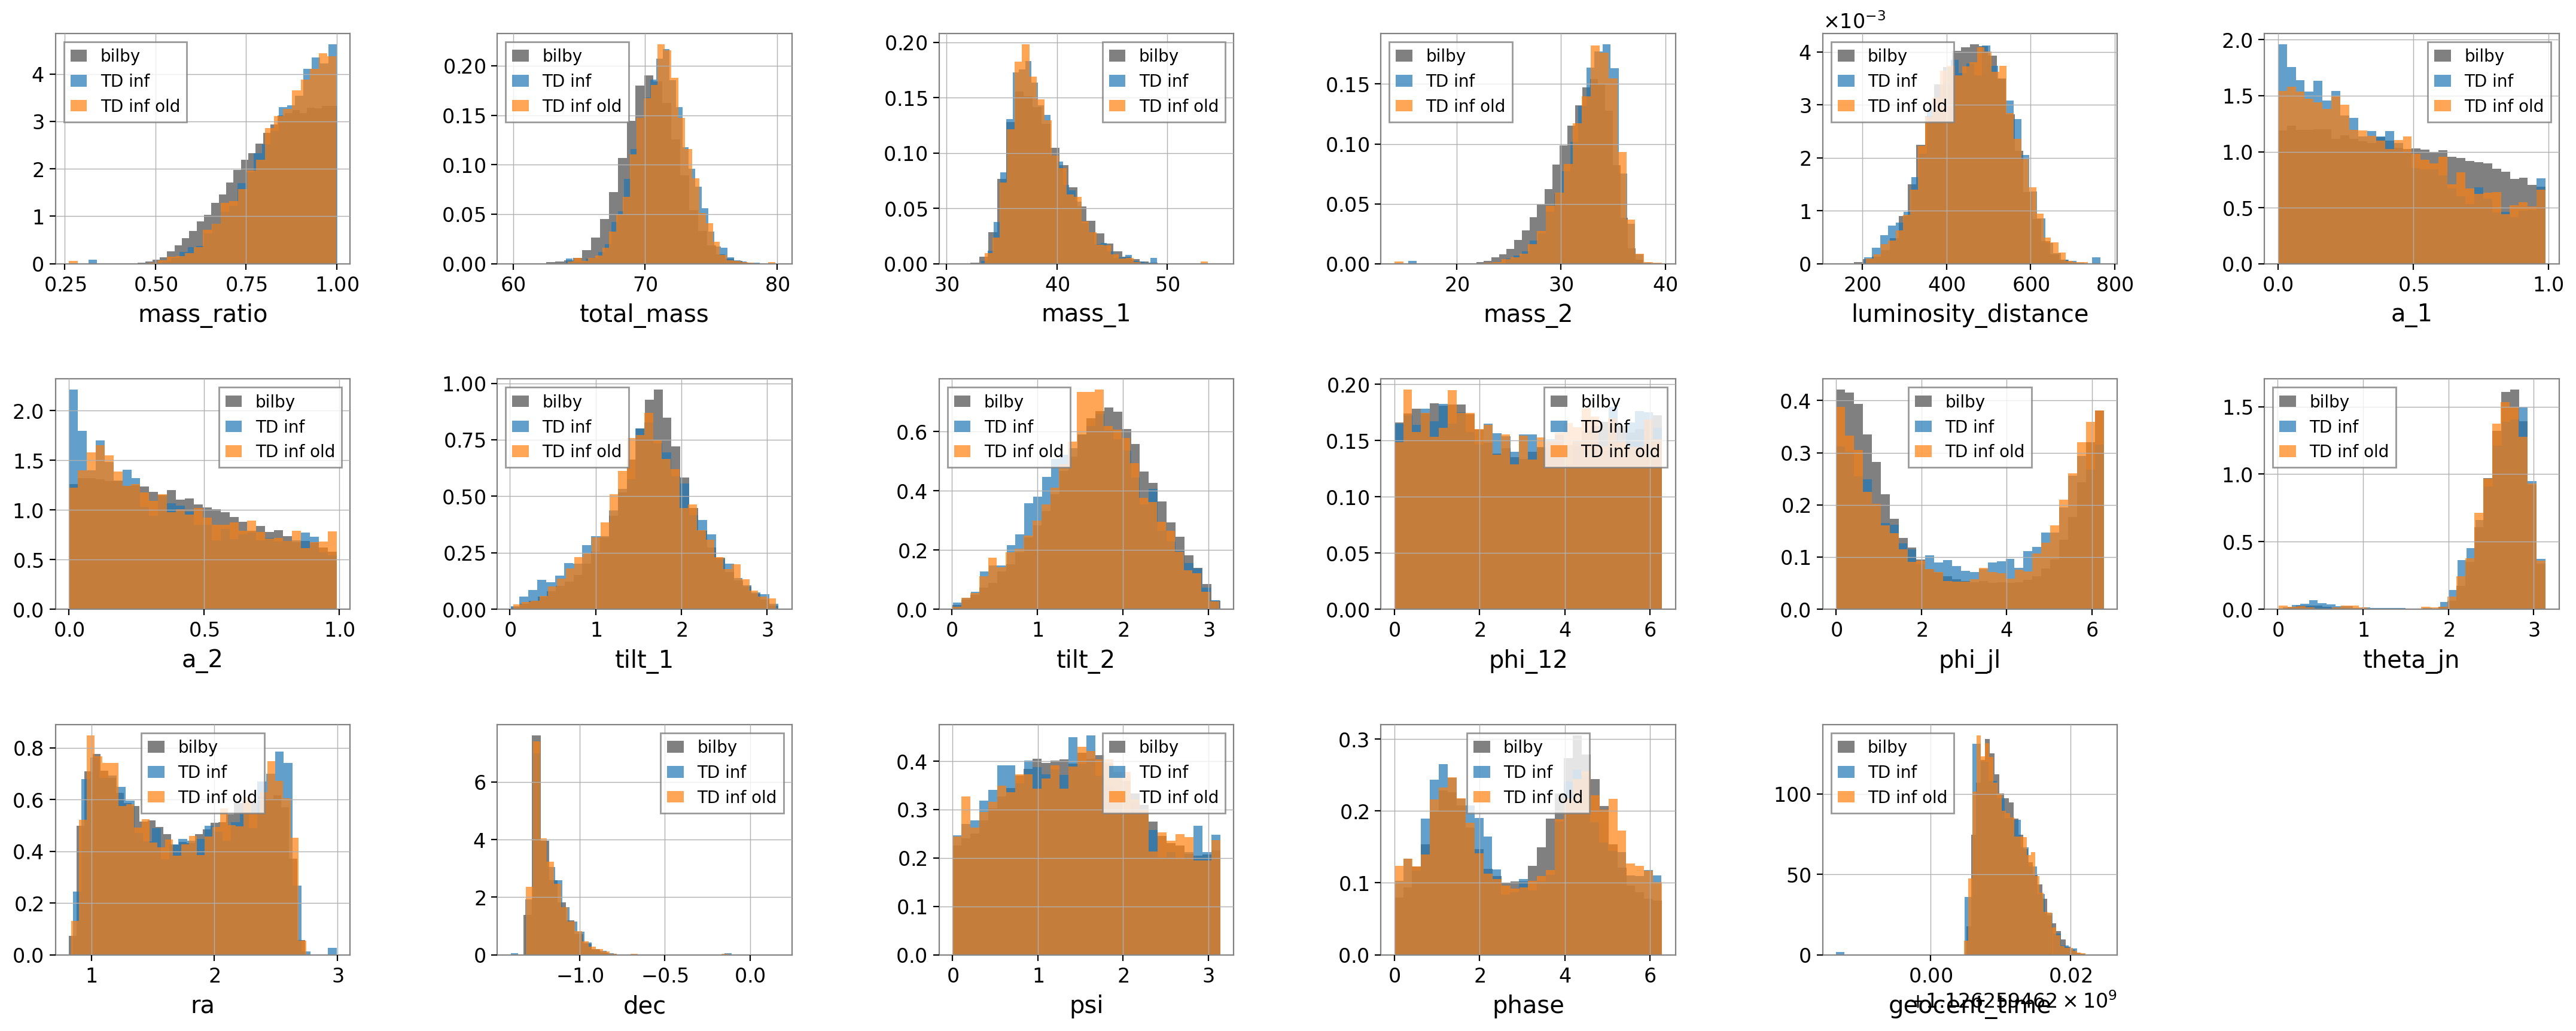

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

for k, ax in zip(key_transform.keys(), axes.flatten()): 

    hist_kws = dict(density=True, bins=30)
    ax.hist(FD_posterior[k], **hist_kws, color='gray',label='bilby')
    ax.hist(TD_posterior[key_transform[k]], **hist_kws,  alpha=0.7, label='TD inf')
    ax.hist(TD_posterior2[key_transform[k]], **hist_kws,  alpha=0.7, label='TD inf old')
        
    ax.set_xlabel(k)
    ax.legend(fontsize=10)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
axes[-1][-1].set_visible(False)
plt.show()

### Plot waveforms

In [10]:
# Load
wfs = waveform_h5s.load_waveform_h5py(f'output/{run}/waveforms/full_waveforms.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'output/250721_output_longer_seg/waveforms/full_waveforms.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def whiten_wfs(wf_dict_list): 
    wf_dict_list_wh = []
    for d in wf_dict_list: 
        d_wh = {ifo:utils.whitenData(
            h_ifo, lm.time_dict[ifo], lm.conditioned_psd_dict[ifo][:,1], lm.conditioned_psd_dict[ifo][:,0]
        ) for ifo, h_ifo in d.items()}
        wf_dict_list_wh.append(d_wh)
    
    return wf_dict_list_wh

# Whiten 
wfs_whitened = whiten_wfs(wfs['samples'])

In [ ]:
# Plot colored
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))
    
    # full
    for j in range(len(wfs['samples'])):
        plt.plot(lm.time_dict[ifo], wfs['samples'][j][ifo], color=f'C{i}', lw=0.5, alpha=0.01)
        
    plt.title(ifo)
    plt.xlabel('GPS time')
    plt.ylabel('strain')
    plt.show()

In [ ]:
# Plot colored
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))
    plt.plot(lm.time_dict[ifo], lm.whitened_data_dict[ifo], color='silver', zorder=0)

    # full
    for j in range(len(wfs_whitened)):
        plt.plot(lm.time_dict[ifo], wfs_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01)
        
    plt.title(ifo)
    plt.xlim(lm.reference_time-0.2, lm.reference_time+0.11)
    plt.ylim(-5.7,5.7)
    plt.xlabel('GPS time')
    plt.ylabel('whitened strain')
    plt.show()

print(lm.time_dict[ifo][-1] - lm.time_dict[ifo][0])

### MCMC chains

In [13]:
import emcee
f = 'output/250721_output_longer_seg/full_0.0seconds/full_0.0seconds.h5'
backend = emcee.backends.HDFBackend(f, read_only=True) 

In [14]:
thin = 500
chain = backend.get_chain(thin=thin)

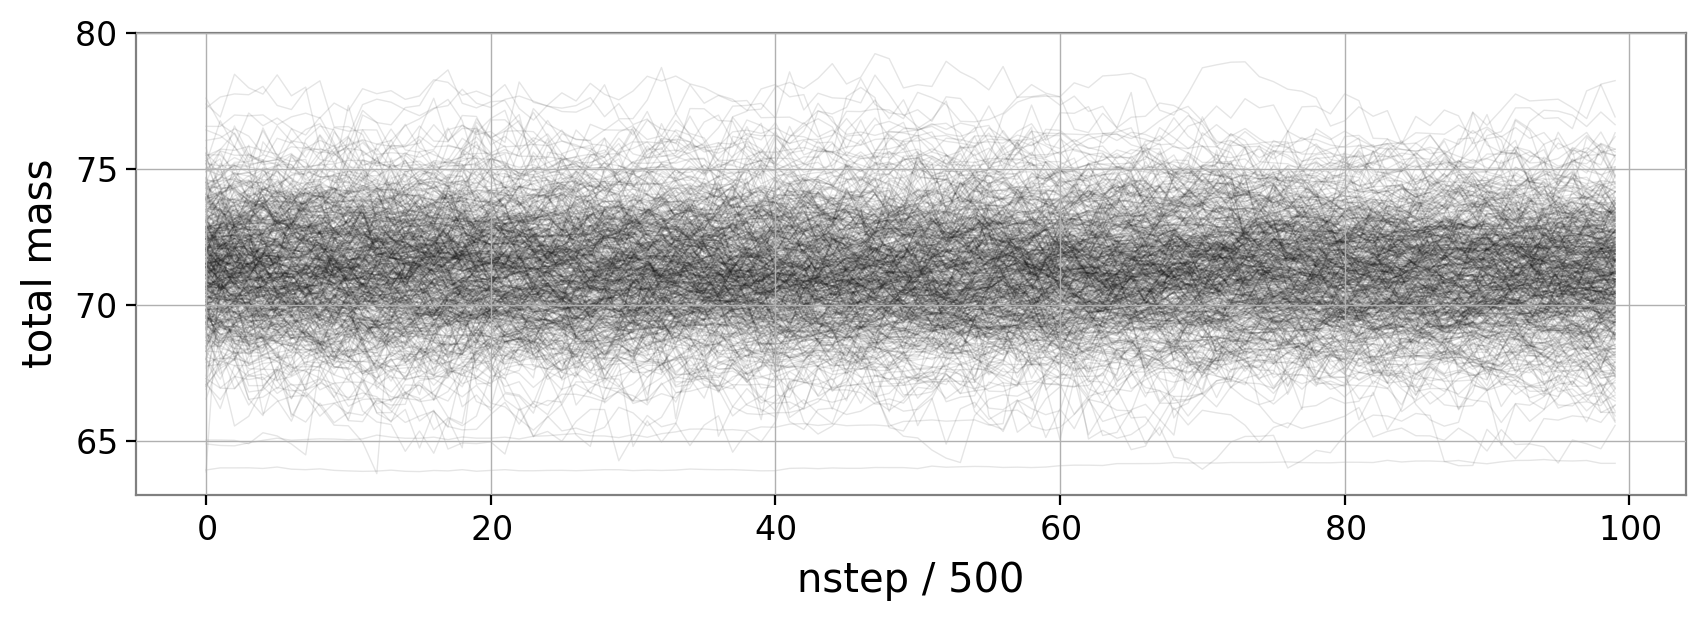

In [15]:
# plot total mass chain
plt.figure(figsize=(10,3))
for ch in chain[:,:,0].T:
    ch_phys = utils.inv_logit(ch, 60, 80)
    plt.plot(ch_phys, color='k', lw=0.5, alpha=0.1)
plt.ylabel('total mass')
plt.xlabel(f'nstep / {thin}');

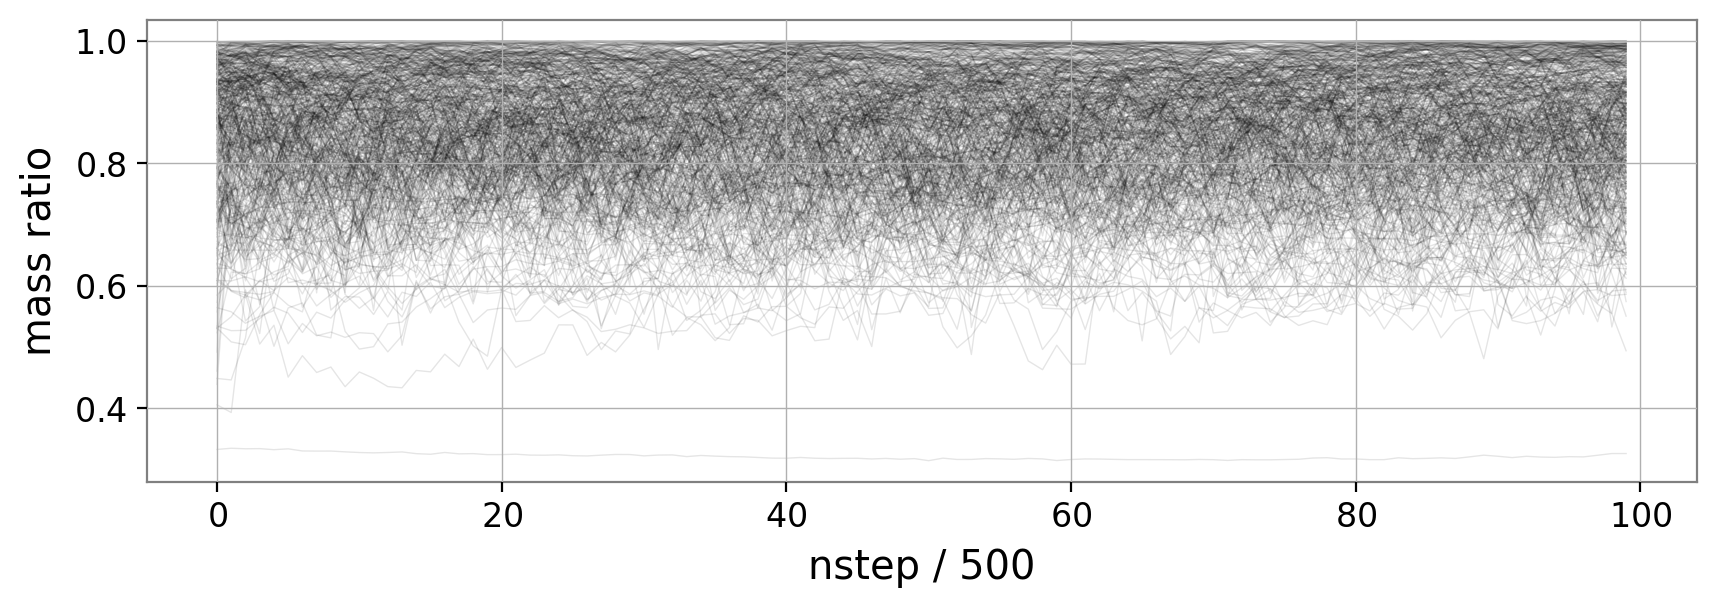

In [16]:
# plot mass ratio chain
plt.figure(figsize=(10,3))
for ch in chain[:,:,1].T:
    ch_phys = utils.inv_logit(ch, 0.25, 1)
    plt.plot(ch_phys, color='k', lw=0.5, alpha=0.1)
plt.ylabel('mass ratio')
plt.xlabel(f'nstep / {thin}');